In [6]:
import os
import boto3
import psycopg
import pandas as pd
import mlflow
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [7]:

TABLE_NAME = "users_churn"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "churn_ivan_panchenko"
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = "churn_model_ivan_panchenko"
FS_ASSETS = "fs_assets"

In [28]:
# Загрузка переменных из .env файла
load_dotenv()

# Функция для получения переменных окружения
def get_env_variable(var_name):
    value = os.getenv(var_name)
    if not value:
        raise ValueError(f"Переменная окружения {var_name} не установлена в файле .env")
    return value

# Получение переменных окружения
S3_ENDPOINT_URL = get_env_variable('S3_ENDPOINT_URL')
S3_BUCKET_NAME = get_env_variable('S3_BUCKET_NAME')
AWS_ACCESS_KEY_ID = get_env_variable('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = get_env_variable('AWS_SECRET_ACCESS_KEY')

# Создание клиента S3
s3 = boto3.client(
    's3',
    endpoint_url=S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

def list_s3_objects():
    try:
        # Получение списка объектов в бакете
        response = s3.list_objects_v2(Bucket=S3_BUCKET_NAME)

        # Проверка, пуст ли бакет
        if 'Contents' not in response:
            print(f"Бакет '{S3_BUCKET_NAME}' пуст.")
            return

        # Вывод списка объектов
        print(f"Объекты в бакете '{S3_BUCKET_NAME}':")
        for obj in response['Contents']:
            print(f"- {obj['Key']} (Размер: {obj['Size']} байт, Последнее изменение: {obj['LastModified']})")

    except ClientError as e:
        print(f"Произошла ошибка: {e}")

# Вызов функции для вывода списка объектов
list_s3_objects()



connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv('DB_DESTINATION_HOST'),
    "port": os.getenv('DB_DESTINATION_PORT'), 
    "dbname": os.getenv('DB_DESTINATION_NAME'), 
    "user": os.getenv('DB_DESTINATION_USER'), 
    "password": os.getenv('DB_DESTINATION_PASSWORD')
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)



with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
				
        data = cur.fetchall()

        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

print(f"Размер нашей таблицы: {df.shape[0]} строк; {df.shape[1]} столбцов")


Объекты в бакете 's3-student-mle-20241121-573777dca2':
- 0/287581d0c77a401b8a2bc3eeaad40cfe/artifacts/models/MLmodel (Размер: 484 байт, Последнее изменение: 2025-08-03 13:22:47.306000+00:00)
- 0/287581d0c77a401b8a2bc3eeaad40cfe/artifacts/models/conda.yaml (Размер: 207 байт, Последнее изменение: 2025-08-03 13:22:47.335000+00:00)
- 0/287581d0c77a401b8a2bc3eeaad40cfe/artifacts/models/model.cb (Размер: 63904 байт, Последнее изменение: 2025-08-03 13:22:47.237000+00:00)
- 0/287581d0c77a401b8a2bc3eeaad40cfe/artifacts/models/python_env.yaml (Размер: 115 байт, Последнее изменение: 2025-08-03 13:22:47.264000+00:00)
- 0/287581d0c77a401b8a2bc3eeaad40cfe/artifacts/models/requirements.txt (Размер: 89 байт, Последнее изменение: 2025-08-03 13:22:47.365000+00:00)
- 0/2b4d7f751a8a451d8bf27e6214ebc988/artifacts/comment.txt (Размер: 89 байт, Последнее изменение: 2025-08-02 12:14:54.784000+00:00)
- 0/4221086470a747c080d599575d568fd7/artifacts/data_description.txt (Размер: 35 байт, Последнее изменение: 2025

In [29]:
df.columns

Index(['id', 'customer_id', 'begin_date', 'end_date', 'type',
       'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'target'],
      dtype='object')

In [32]:
df.columns

Index(['id', 'customer_id', 'begin_date', 'end_date', 'type',
       'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'target'],
      dtype='object')

In [45]:
# определение категориальных колонок, которые будут преобразованы
cat_columns = ["type", "payment_method", "internet_service", "gender"]

# создание объекта OneHotEncoder для преобразования категориальных переменных
# auto - автоматическое определение категорий
# ignore - игнорировать ошибки, если встречается неизвестная категория
# max_categories - максимальное количество уникальных категорий
# sparse_output - вывод в виде разреженной матрицы, если False, то в виде обычного массива
# drop="first" - удаляет первую категорию, чтобы избежать ловушки мультиколлинеарности
encoder_oh = OneHotEncoder(categories='auto', handle_unknown='ignore', max_categories=10, sparse_output=False, drop='first')

# применение OneHotEncoder к данным. Преобразование категориальных данных в массив

encoded_features = encoder_oh.fit_transform(df[cat_columns].to_numpy())

# преобразование полученных признаков в DataFrame и установка названий колонок
# get_feature_names_out() - получение имён признаков после преобразования
encoded_df = pd.DataFrame(encoded_features, columns=encoder_oh.get_feature_names_out(cat_columns))

# конкатенация исходного DataFrame с новым DataFrame, содержащим закодированные категориальные признаки
# axis=1 означает конкатенацию по колонкам
obj_df = pd.concat([df, encoded_df], axis=1)

obj_df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,multiple_lines,target,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_None,gender_Male
0,17,8191-XWSZG,2015-10-01,NaT,One year,No,Mailed check,20.65,1022.95,None,...,No,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,59,3957-SQXML,2017-04-01,NaT,Two year,No,Credit card (automatic),24.95,894.30,None,...,Yes,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [47]:
from sklearn.impute import SimpleImputer
import os
import boto3
from botocore.exceptions import ClientError
from dotenv import load_dotenv
import pandas as pd
import psycopg2 as psycopg
import mlflow
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)

num_columns = ["monthly_charges", "total_charges"]

n_knots = 3
degree_spline = 4
n_quantiles = 100
degree = 3
n_bins = 5
encode = 'ordinal'
strategy = 'uniform'
subsample = None

# Предобработка данных для устранения NaN
imputer = SimpleImputer(strategy='mean')
df[num_columns] = imputer.fit_transform(df[num_columns])

# SplineTransformer
encoder_spl = SplineTransformer(n_knots=n_knots, degree=degree_spline)
encoded_features = encoder_spl.fit_transform(df[num_columns].to_numpy())
encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder_spl.get_feature_names_out(num_columns)
)
num_df = df[num_columns].copy()
num_df = pd.concat([num_df, encoded_df], axis=1)

# QuantileTransformer
encoder_q = QuantileTransformer(n_quantiles=n_quantiles)
encoded_features = encoder_q.fit_transform(df[num_columns].to_numpy())
encoded_df = pd.DataFrame(encoded_features, columns=encoder_q.get_feature_names_out(num_columns))
encoded_df.columns = [col + f"_q_{n_quantiles}" for col in num_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)

# RobustScaler
encoder_rb = RobustScaler()
encoded_features = encoder_rb.fit_transform(df[num_columns].to_numpy())
encoded_df = pd.DataFrame(encoded_features, columns=encoder_rb.get_feature_names_out(num_columns))
encoded_df.columns = [col + f'_robust' for col in num_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)

# PolynomialFeatures
encoder_pol = PolynomialFeatures(degree=degree)
encoded_features = encoder_pol.fit_transform(df[num_columns].to_numpy())
encoded_df = pd.DataFrame(encoded_features, columns=encoder_pol.get_feature_names_out(num_columns))
# get all columns after the intercept and original features
encoded_df = encoded_df.iloc[:, 1 + len(num_columns):]
encoded_df.columns = [col + "_poly" for col in encoded_df.columns]
num_df = pd.concat([num_df, encoded_df], axis=1)

# KBinsDiscretizer
encoder_kbd = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy, subsample=subsample)
encoded_features = encoder_kbd.fit_transform(df[num_columns].to_numpy())
encoded_df = pd.DataFrame(encoded_features, columns=encoder_kbd.get_feature_names_out(num_columns))
encoded_df.columns = [col + f'_bin' for col in num_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)

num_df.head(2)

,monthly_charges,total_charges,monthly_charges_sp_0,monthly_charges_sp_1,monthly_charges_sp_2,monthly_charges_sp_3,monthly_charges_sp_4,monthly_charges_sp_5,total_charges_sp_0,total_charges_sp_1,...,total_charges_robust,monthly_charges^2_poly,monthly_charges total_charges_poly,total_charges^2_poly,monthly_charges^3_poly,monthly_charges^2 total_charges_poly,monthly_charges total_charges^2_poly,total_charges^3_poly,monthly_charges_bin,total_charges_bin
0,20.65,1022.95,0.034259,0.433936,0.481590,0.050214,2.168151e-07,0.0,0.014515,0.334777,...,-0.111572,426.4225,21123.9175,1.046427e+06,8805.624625,436208.896375,2.160871e+07,1.070442e+09,0.0,0.0
1,24.95,894.30,0.023507,0.388355,0.519449,0.068676,1.316872e-05,0.0,0.016892,0.350947,...,-0.149584,622.5025,22312.7850,7.997725e+05,15531.437375,556703.985750,1.995432e+07,7.152365e+08,0.0,0.0


In [48]:
numeric_transformer = ColumnTransformer(
    transformers=[
        ('spl', encoder_spl, num_columns), 
        ('q', encoder_q, num_columns), 
        ('rb', encoder_rb, num_columns), 
        ('pol', encoder_pol, num_columns), 
        ('kbd', encoder_kbd, num_columns)
    ]
)

categorical_transformer = Pipeline(steps=[('encoder', encoder_oh)])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, num_columns), 
                  ('cat', categorical_transformer, cat_columns)], 
    n_jobs=-1)

encoded_features = preprocessor.fit_transform(df)

transformed_df = pd.DataFrame(
    encoded_features, 
    columns=preprocessor.get_feature_names_out()
)

df = pd.concat([df, transformed_df], axis=1)

df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,num__kbd__monthly_charges,num__kbd__total_charges,cat__type_One year,cat__type_Two year,cat__payment_method_Credit card (automatic),cat__payment_method_Electronic check,cat__payment_method_Mailed check,cat__internet_service_Fiber optic,cat__internet_service_None,cat__gender_Male
0,17,8191-XWSZG,2015-10-01,NaT,One year,No,Mailed check,20.65,1022.95,None,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,59,3957-SQXML,2017-04-01,NaT,Two year,No,Credit card (automatic),24.95,894.30,None,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [51]:
# Безопасное удаление колонок
columns_to_drop = ['id', 'customer_id', 'begin_date', 'end_date']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=columns_to_drop, errors='ignore')

# Определение категориальных и числовых колонок
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
cat_columns = [col for col in cat_columns if col != 'target']
num_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# One-hot кодирование категориальных признаков
df_encoded = pd.get_dummies(df, columns=cat_columns)

# Разделение данных
X_train_features, X_test, y_train, y_test = train_test_split(
    df_encoded.drop('target', axis=1), 
    df_encoded['target'], 
    test_size=0.2, 
    random_state=42
)

In [53]:
# Prepare the estimator (Random Forest)
estimator = RandomForestClassifier(n_estimators=3)

# Prepare feature selection methods

sfs = SFS(estimator, k_features=10, forward=True, floating=False, scoring='roc_auc', cv=4, n_jobs=-1)

sbs = SFS(estimator, k_features=10, forward=False, floating=False, scoring='roc_auc', cv=4, n_jobs=-1)

# Perform feature selection
sfs = sfs.fit(X_train_features, y_train)
sbs = sbs.fit(X_train_features, y_train)

# Get top features

top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_


print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)



Sequential Forward Selection (k=10)
CV Score:
0.8191390396847581

Sequential Backward Selection
CV Score:
0.7345080353055798


In [54]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T

In [55]:
os.mkdir(FS_ASSETS)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv")

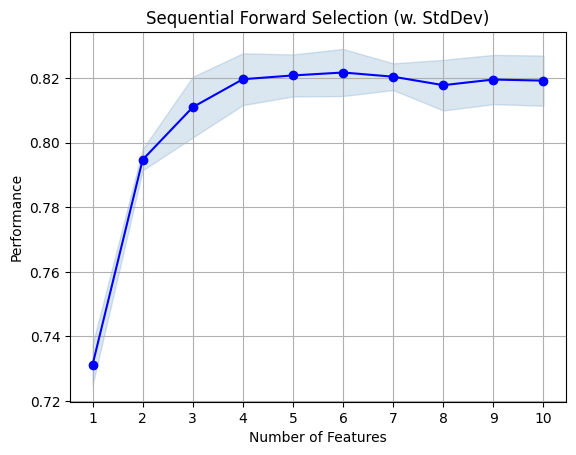

<Figure size 640x480 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png")

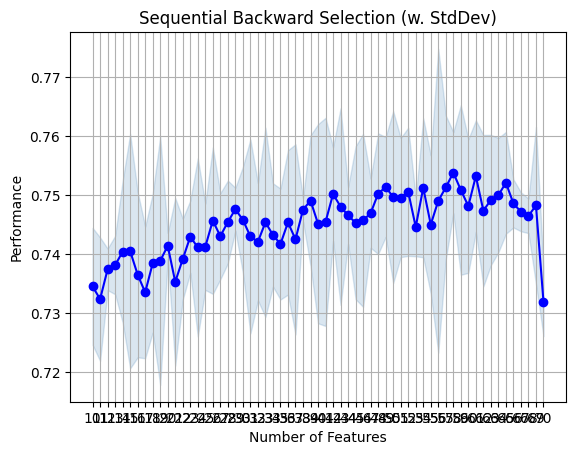

<Figure size 640x480 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png")

In [59]:

interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

In [60]:
interc_features

['cat__internet_service_Fiber optic', 'type_One year']

In [61]:
union_features

['online_security_No',
 'cat__internet_service_None',
 'type_Month-to-month',
 'cat__internet_service_Fiber optic',
 'num__pol__1',
 'type_One year',
 'type_Two year',
 'num__spl__total_charges_sp_2',
 'cat__gender_Male',
 'num__kbd__total_charges',
 'partner_Yes',
 'paperless_billing_Yes',
 'tech_support_No',
 'num__pol__monthly_charges^3',
 'paperless_billing_No',
 'payment_method_Mailed check',
 'cat__payment_method_Credit card (automatic)',
 'num__pol__monthly_charges total_charges']

In [66]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = get_env_variable("S3_ENDPOINT_URL")
os.environ["AWS_ACCESS_KEY_ID"] = get_env_variable("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = get_env_variable("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id


with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS)

In [69]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Prepare features for intersection and union
X_interc = X_encoded_df[interc_features]
X_union = X_encoded_df[union_features]

# Split data for both feature sets
X_interc_train, X_interc_test, y_interc_train, y_interc_test = train_test_split(
    X_interc, y, test_size=0.2, random_state=42
)
X_union_train, X_union_test, y_union_train, y_union_test = train_test_split(
    X_union, y, test_size=0.2, random_state=42
)

# MLflow experiment setup
mlflow.set_experiment('feature_selection_intersection')

# Train and log model with intersected features
with mlflow.start_run(run_name='intersected_features_rf'):
    # Train model
    rf_interc = RandomForestClassifier(n_estimators=300, random_state=42)
    rf_interc.fit(X_interc_train, y_interc_train)
    
    # Predict and evaluate
    y_pred_interc = rf_interc.predict(X_interc_test)
    y_pred_proba_interc = rf_interc.predict_proba(X_interc_test)[:, 1]
    
    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_score(y_interc_test, y_pred_interc),
        'precision': precision_score(y_interc_test, y_pred_interc),
        'recall': recall_score(y_interc_test, y_pred_interc),
        'f1_score': f1_score(y_interc_test, y_pred_interc),
        'roc_auc': roc_auc_score(y_interc_test, y_pred_proba_interc)
    })
    
    # Log model
    mlflow.sklearn.log_model(rf_interc, 'intersected_features_model')
    
    # Get run details
    run_interc = mlflow.active_run()
    run_id_interc = run_interc.info.run_id

# MLflow experiment setup for union features
mlflow.set_experiment('feature_selection_union')

# Train and log model with union features
with mlflow.start_run(run_name='union_features_rf'):
    # Train model
    rf_union = RandomForestClassifier(n_estimators=300, random_state=42)
    rf_union.fit(X_union_train, y_union_train)
    
    # Predict and evaluate
    y_pred_union = rf_union.predict(X_union_test)
    y_pred_proba_union = rf_union.predict_proba(X_union_test)[:, 1]
    
    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_score(y_union_test, y_pred_union),
        'precision': precision_score(y_union_test, y_pred_union),
        'recall': recall_score(y_union_test, y_pred_union),
        'f1_score': f1_score(y_union_test, y_pred_union),
        'roc_auc': roc_auc_score(y_union_test, y_pred_proba_union)
    })
    
    # Log model
    mlflow.sklearn.log_model(rf_union, 'union_features_model')
    
    # Get run details
    run_union = mlflow.active_run()
    run_id_union = run_union.info.run_id

# Prepare variables for registration
registred_model_name = 'feature_selection_comparison'

# Register models
client = mlflow.tracking.MlflowClient()

# Register intersected features model
model_version_id_interc = client.create_model_version(
    name=registred_model_name,
    source=f"runs:/{run_id_interc}/intersected_features_model",
    run_id=run_id_interc
).version

# Register union features model
model_version_id_union = client.create_model_version(
    name=registred_model_name,
    source=f"runs:/{run_id_union}/union_features_model",
    run_id=run_id_union
).version

# Print out the details for manual input
print("Intersected Features Model:")
print("Run ID:", run_id_interc)
print("Model Version ID:", model_version_id_interc)

print("\nUnion Features Model:")
print("Run ID:", run_id_union)
print("Model Version ID:", model_version_id_union)

KeyError: "['cat__internet_service_Fiber optic'] not in index"

In [70]:
# Ensure feature names match exactly with the column names in X_encoded_df
print("Actual column names:", list(X_encoded_df.columns))
print("\nIntersecting features:", interc_features)
print("\nUnion features:", union_features)

# Modify feature selection to use exact column names
X_interc = X_encoded_df[[col for col in interc_features if col in X_encoded_df.columns]]
X_union = X_encoded_df[[col for col in union_features if col in X_encoded_df.columns]]

Actual column names: ['monthly_charges', 'total_charges', 'type_Month-to-month', 'type_One year', 'type_Two year', 'paperless_billing_No', 'paperless_billing_Yes', 'payment_method_Bank transfer (automatic)', 'payment_method_Credit card (automatic)', 'payment_method_Electronic check', 'payment_method_Mailed check', 'internet_service_DSL', 'internet_service_Fiber optic', 'online_security_No', 'online_security_Yes', 'online_backup_No', 'online_backup_Yes', 'device_protection_No', 'device_protection_Yes', 'tech_support_No', 'tech_support_Yes', 'streaming_tv_No', 'streaming_tv_Yes', 'streaming_movies_No', 'streaming_movies_Yes', 'gender_Female', 'gender_Male', 'senior_citizen_0', 'senior_citizen_1', 'partner_No', 'partner_Yes', 'dependents_No', 'dependents_Yes', 'multiple_lines_No', 'multiple_lines_Yes', 'target']

Intersecting features: ['cat__internet_service_Fiber optic', 'type_One year']

Union features: ['online_security_No', 'cat__internet_service_None', 'type_Month-to-month', 'cat__i

In [71]:
# Remove the 'cat__' and other prefixes from feature names
interc_features_cleaned = [col.replace('cat__', '').replace('num__', '').replace('pol__', '') for col in interc_features]
union_features_cleaned = [col.replace('cat__', '').replace('num__', '').replace('pol__', '') for col in union_features]

# Select features from the DataFrame
X_interc = X_encoded_df[[col for col in interc_features_cleaned if col in X_encoded_df.columns]]
X_union = X_encoded_df[[col for col in union_features_cleaned if col in X_encoded_df.columns]]

# Verify the selected features
print("Intersecting features selected:", list(X_interc.columns))
print("Union features selected:", list(X_union.columns))

Intersecting features selected: ['internet_service_Fiber optic', 'type_One year']
Union features selected: ['online_security_No', 'type_Month-to-month', 'internet_service_Fiber optic', 'type_One year', 'type_Two year', 'gender_Male', 'partner_Yes', 'paperless_billing_Yes', 'tech_support_No', 'paperless_billing_No', 'payment_method_Mailed check', 'payment_method_Credit card (automatic)']


In [79]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Prepare features for intersection and union
X_interc = X_encoded_df[['internet_service_Fiber optic', 'type_One year']]
X_union = X_encoded_df[['online_security_No', 'type_Month-to-month', 'internet_service_Fiber optic', 'type_One year', 'type_Two year', 'gender_Male', 'partner_Yes', 'paperless_billing_Yes', 'tech_support_No', 'paperless_billing_No', 'payment_method_Mailed check', 'payment_method_Credit card (automatic)']]

# Split data for both feature sets
X_interc_train, X_interc_test, y_interc_train, y_interc_test = train_test_split(
    X_interc, y, test_size=0.2, random_state=42
)
X_union_train, X_union_test, y_union_train, y_union_test = train_test_split(
    X_union, y, test_size=0.2, random_state=42
)

# MLflow experiment setup
mlflow.set_experiment('feature_selection_intersection')

# Train and log model with intersected features
with mlflow.start_run(run_name='intersected_features_rf'):
    # Train model
    rf_interc = RandomForestClassifier(n_estimators=300, random_state=42)
    rf_interc.fit(X_interc_train, y_interc_train)
    
    # Predict and evaluate
    y_pred_interc = rf_interc.predict(X_interc_test)
    
    # Check if the model supports probability predictions
    if hasattr(rf_interc, 'predict_proba'):
        y_pred_proba_interc = rf_interc.predict_proba(X_interc_test)
        # Handle binary and multiclass cases
        if y_pred_proba_interc.shape[1] > 1:
            y_pred_proba_interc = y_pred_proba_interc[:, 1]
        else:
            y_pred_proba_interc = y_pred_proba_interc.ravel()
    else:
        # Fallback if no probability predictions
        y_pred_proba_interc = y_pred_interc
    
    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_score(y_interc_test, y_pred_interc),
        'precision': precision_score(y_interc_test, y_pred_interc),
        'recall': recall_score(y_interc_test, y_pred_interc),
        'f1_score': f1_score(y_interc_test, y_pred_interc),
        'roc_auc': roc_auc_score(y_interc_test, y_pred_proba_interc)
    })
    
    # Log model
    mlflow.sklearn.log_model(rf_interc, 'intersected_features_model')
    
    # Get run details
    run_interc = mlflow.active_run()
    run_id_interc = run_interc.info.run_id

# Similar modifications for union features model...

/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tr

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [81]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prepare features for intersection and union
X_interc = X_encoded_df[['internet_service_Fiber optic', 'type_One year']]
X_union = X_encoded_df[['online_security_No', 'type_Month-to-month', 'internet_service_Fiber optic', 'type_One year', 'type_Two year', 'gender_Male', 'partner_Yes', 'paperless_billing_Yes', 'tech_support_No', 'paperless_billing_No', 'payment_method_Mailed check', 'payment_method_Credit card (automatic)']]

# Split data for both feature sets
X_interc_train, X_interc_test, y_interc_train, y_interc_test = train_test_split(
    X_interc, y, test_size=0.2, random_state=42
)
X_union_train, X_union_test, y_union_train, y_union_test = train_test_split(
    X_union, y, test_size=0.2, random_state=42
)

# MLflow experiment setup
mlflow.set_experiment(EXPERIMENT_NAME)

# Train and log model with intersected features
with mlflow.start_run(run_name='intersected_features_rf'):
    # Train model
    rf_interc = RandomForestClassifier(n_estimators=300, random_state=42)
    rf_interc.fit(X_interc_train, y_interc_train)
    
    # Predict and evaluate
    y_pred_interc = rf_interc.predict(X_interc_test)
    
    # Check class distribution
    print("Unique classes in test set:", set(y_interc_test))
    
    # Log metrics (excluding ROC AUC)
    mlflow.log_metrics({
        'accuracy': accuracy_score(y_interc_test, y_pred_interc),
        'precision': precision_score(y_interc_test, y_pred_interc),
        'recall': recall_score(y_interc_test, y_pred_interc),
        'f1_score': f1_score(y_interc_test, y_pred_interc)
    })
    
    # Log model
    mlflow.sklearn.log_model(rf_interc, 'intersected_features_model')
    
    # Get run details
    run_interc = mlflow.active_run()
    run_id_interc = run_interc.info.run_id

# Similar approach for union features model

Unique classes in test set: {0}


/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tr

In [82]:
# MLflow experiment setup for union features
mlflow.set_experiment(EXPERIMENT_NAME)

# Train and log model with union features
with mlflow.start_run(run_name='union_features_rf'):
    # Train model
    rf_union = RandomForestClassifier(n_estimators=300, random_state=42)
    rf_union.fit(X_union_train, y_union_train)
    
    # Predict and evaluate
    y_pred_union = rf_union.predict(X_union_test)
    
    # Check class distribution
    print("Unique classes in test set:", set(y_union_test))
    
    # Log metrics (excluding ROC AUC)
    mlflow.log_metrics({
        'accuracy': accuracy_score(y_union_test, y_pred_union),
        'precision': precision_score(y_union_test, y_pred_union),
        'recall': recall_score(y_union_test, y_pred_union),
        'f1_score': f1_score(y_union_test, y_pred_union)
    })
    
    # Log model
    mlflow.sklearn.log_model(rf_union, 'union_features_model')
    
    # Get run details
    run_union = mlflow.active_run()
    run_id_union = run_union.info.run_id

Unique classes in test set: {0}


/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tr

In [83]:

import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prepare features for intersection and union
X_interc = X_encoded_df[['internet_service_Fiber optic', 'type_One year']]
X_union = X_encoded_df[['online_security_No', 'type_Month-to-month', 'internet_service_Fiber optic', 'type_One year', 'type_Two year', 'gender_Male', 'partner_Yes', 'paperless_billing_Yes', 'tech_support_No', 'paperless_billing_No', 'payment_method_Mailed check', 'payment_method_Credit card (automatic)']]

# Split data for both feature sets
X_interc_train, X_interc_test, y_interc_train, y_interc_test = train_test_split(
    X_interc, y, test_size=0.2, random_state=42
)
X_union_train, X_union_test, y_union_train, y_union_test = train_test_split(
    X_union, y, test_size=0.2, random_state=42
)

# Define the registered model name
registred_model_name = 'churn_model_ivan_panchenko'

# MLflow experiment setup
mlflow.set_experiment(EXPERIMENT_NAME)

# Train and log model with intersected features
with mlflow.start_run(run_name='churn_model_ivan_panchenko'):
    # Train model
    rf_interc = RandomForestClassifier(n_estimators=300, random_state=42)
    rf_interc.fit(X_interc_train, y_interc_train)
    
    # Predict and evaluate
    y_pred_interc = rf_interc.predict(X_interc_test)
    
    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_score(y_interc_test, y_pred_interc),
        'precision': precision_score(y_interc_test, y_pred_interc),
        'recall': recall_score(y_interc_test, y_pred_interc),
        'f1_score': f1_score(y_interc_test, y_pred_interc)
    })
    
    # Log and register model
    model_info_interc = mlflow.sklearn.log_model(rf_interc, 'intersected_features_model')
    
    # Get current run details
    run_interc = mlflow.active_run()
    run_name_interc = run_interc.info.run_name
    run_id_interc = run_interc.info.run_id
    
    # Register the model
    model_version_interc = mlflow.register_model(
        model_uri=model_info_interc.model_uri,
        name=registred_model_name
    )
    model_version_id_interc = model_version_interc.version
    model_registred_name_interc = registred_model_name

# Train and log model with union features
with mlflow.start_run(run_name='churn_model_ivan_panchenko'):
    # Train model
    rf_union = RandomForestClassifier(n_estimators=300, random_state=42)
    rf_union.fit(X_union_train, y_union_train)
    
    # Predict and evaluate
    y_pred_union = rf_union.predict(X_union_test)
    
    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_score(y_union_test, y_pred_union),
        'precision': precision_score(y_union_test, y_pred_union),
        'recall': recall_score(y_union_test, y_pred_union),
        'f1_score': f1_score(y_union_test, y_pred_union)
    })
    
    # Log and register model
    model_info_union = mlflow.sklearn.log_model(rf_union, 'union_features_model')
    
    # Get current run details
    run_union = mlflow.active_run()
    run_name_union = run_union.info.run_name
    run_id_union = run_union.info.run_id
    
    # Register the model
    model_version_union = mlflow.register_model(
        model_uri=model_info_union.model_uri,
        name=registred_model_name
    )
    model_version_id_union = model_version_union.version
    model_registred_name_union = registred_model_name

# Print out the variables to confirm
print(f"registred_model_name = '{registred_model_name}'")
print(f"model_version_id_interc = {model_version_id_interc}")
print(f"run_name_interc = '{run_name_interc}'")
print(f"run_id_interc = '{run_id_interc}'")
print(f"model_version_id_union = {model_version_id_union}")
print(f"run_name_union = '{run_name_union}'")
print(f"run_id_union = '{run_id_union}'")
print(f"model_registred_name_interc = '{model_registred_name_interc}'")
print(f"model_registred_name_union = '{model_registred_name_union}'")


/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mle-user/mle_projects/mle-mlflow/mlflow_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(tr

registred_model_name = 'churn_model_ivan_panchenko'
model_version_id_interc = 9
run_name_interc = 'churn_model_ivan_panchenko'
run_id_interc = '39f2251c42624af0b9cd4270ada0908f'
model_version_id_union = 10
run_name_union = 'churn_model_ivan_panchenko'
run_id_union = '8dcd6177fb274fe4a11bd986a0ea6892'
model_registred_name_interc = 'churn_model_ivan_panchenko'
model_registred_name_union = 'churn_model_ivan_panchenko'


Created version '10' of model 'churn_model_ivan_panchenko'.
